<a href="https://colab.research.google.com/github/Hdr2030/Computer-Vision-Matarials/blob/main/Detect_Track_and_count_with_yolov8_%26_Supervision1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Video Link: https://drive.google.com/drive/folders/18t7_Qj2QS3lg0b2e9D8lUMYyPIIZomew?usp=sharing

In [1]:
!nvidia-smi

Wed Feb  7 19:43:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%pwd

'C:\\Users\\habib\\Downloads\\Computer-Vision-Matarials-main\\Computer-Vision-Matarials-main'

## Upload video

In [2]:
SOURCE_VIDEO_PATH_1 = "/content/video.mp4.mp4"


## Install YOLOv8

In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.4/709.4 kB 15.6 MB/s eta 0:00:00


In [3]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.8/78.2 GB disk)


## Install ByteTrack

In [4]:
import os
HOME = os.getcwd()

In [6]:
%pwd

'/content'

In [5]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [6]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass

## Install Roboflow Supervision

In [17]:
!pip install supervision==0.1.0

In [8]:
from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


## Load pre-trained YOLOv8 model

In [9]:
# settings
MODEL = "yolov8x.pt"

In [10]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [11]:
%cd /content

/content


In [11]:
%pwd

'/content'

In [12]:
!yolo task=detect mode=predict model=yolov8x.pt conf=0.25 source={SOURCE_VIDEO_PATH_1}

Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs

video 1/1 (1/166) /content/video.mp4.mp4: 640x512 10 persons, 4 handbags, 219.4ms
video 1/1 (2/166) /content/video.mp4.mp4: 640x512 11 persons, 3 handbags, 74.0ms
video 1/1 (3/166) /content/video.mp4.mp4: 640x512 10 persons, 3 handbags, 66.6ms
video 1/1 (4/166) /content/video.mp4.mp4: 640x512 8 persons, 2 handbags, 61.0ms
video 1/1 (5/166) /content/video.mp4.mp4: 640x512 9 persons, 1 handbag, 56.9ms
video 1/1 (6/166) /content/video.mp4.mp4: 640x512 10 persons, 3 handbags, 38.5ms
video 1/1 (7/166) /content/video.mp4.mp4: 640x512 12 persons, 5 handbags, 1 cell phone, 39.0ms
video 1/1 (8/166) /content/video.mp4.mp4: 640x512 11 persons, 4 handbags, 1 cell phone, 38.4ms
video 1/1 (9/166) /content/video.mp4.mp4: 640x512 9 persons, 4 handbags, 1 cell phone, 39.3ms
video 1/1 (10/166) /content/video.mp4.mp4: 640x512 8 persons

In [13]:
from supervision.video.source import get_video_frames_generator
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.draw.color import ColorPalette

In [14]:
CLASS_NAMES_DICT = model.model.names
CLASS_NAMES_DICT

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

## Predict and annotate single frame

In [15]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [0,3, 5, 7]


0: 640x512 10 persons, 4 handbags, 117.2ms
Speed: 4.1ms preprocess, 117.2ms inference, 625.1ms postprocess per image at shape (1, 3, 640, 512)


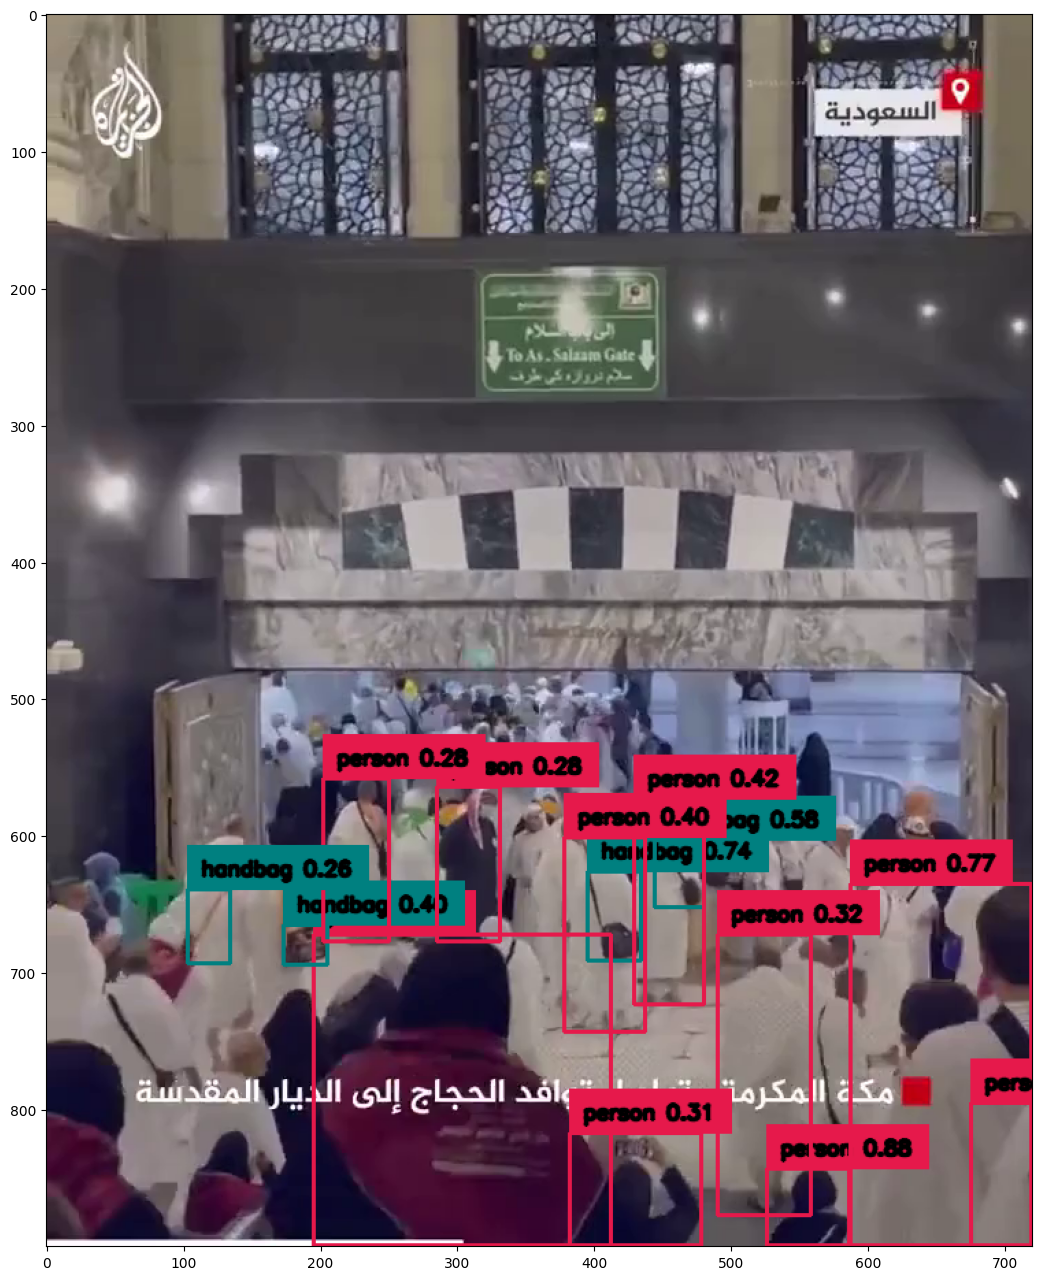

In [16]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH_1)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=0.5)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Detect_Track_and_count whole video

In [52]:
from dataclasses import dataclass
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 0.5
    mot20: bool = False

In [ ]:
%pwd

'/content'

In [25]:
SOURCE_VIDEO_PATH_1 = "/content/video.mp4.mp4"

In [18]:
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
from supervision.video.sink import VideoSink
import numpy as np

In [53]:
# settings
LINE_START = Point(150, 600)
LINE_END = Point(720, 600)

#TARGET_VIDEO_PATH1 = "4"

In [54]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH_1)

VideoInfo(width=720, height=900, fps=29, total_frames=166)

In [55]:
!pip install typing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=5b8c2f94435894c9172aa1e975013ca76dd4a21e2639d460cc2c555e71bfea0b
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


In [55]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([track.tlbr for track in tracks], dtype=float)

# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [57]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH_1)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH_1)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/166 [00:00<?, ?it/s]


0: 640x512 10 persons, 4 handbags, 74.1ms
Speed: 4.4ms preprocess, 74.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 11 persons, 3 handbags, 74.2ms
Speed: 3.7ms preprocess, 74.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 10 persons, 3 handbags, 46.5ms
Speed: 3.4ms preprocess, 46.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 8 persons, 2 handbags, 45.8ms
Speed: 3.1ms preprocess, 45.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 9 persons, 1 handbag, 44.7ms
Speed: 4.4ms preprocess, 44.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 10 persons, 3 handbags, 38.0ms
Speed: 2.4ms preprocess, 38.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 12 persons, 5 handbags, 1 cell phone, 39.1ms
Speed: 3.3ms preprocess, 39.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x5